# NVDA and CAKE Summary Statistics

In [5]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import warnings
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)


In [6]:
# Split up and prepare dataset

# MBO schema
#df_mbo_init = pd.read_csv('xnas-itch-20240822.mbo.csv', parse_dates=['ts_recv', 'ts_event'])


In [7]:
# TBBO Schema
nvda_df = pd.read_csv('xnas-itch-20240822.tbbo.NVDA.csv', parse_dates=['ts_recv', 'ts_event'])
cake_df = pd.read_csv('xnas-itch-20240822.tbbo.CAKE.csv', parse_dates=['ts_recv', 'ts_event'])

#nvda_df_mbo = df_mbo_init[df_mbo_init['symbol'] == 'NVDA'].copy()
#cake_df_mbo = df_mbo_init[df_mbo_init['symbol'] == 'CAKE'].copy()
cake_df_mbo = pd.read_csv('xnas-itch-20240822.mbo.CAKE.csv', parse_dates=['ts_recv', 'ts_event'])

# Helper functions - contain functionality that calculates results

In [38]:
def calculate_5s_price_impact(df):
    ''' Calculates 5 second price impact. '''

    # Calculate the midpoint price
    df['midpoint'] = (df['bid_price'] + df['ask_price']) / 2

    # Lag midpoint by 5 seconds
    df['midpoint_lag'] = df['midpoint'].shift(5)

    # Calculate the midpoint return
    df['midpoint_return'] = df['midpoint'] - df['midpoint_lag']

    # Create a trade sign column based on the 'side' (-1 for 'Ask', +1 for 'Bid')
    df['trade_sign'] = df['side'].apply(lambda x: 1 if x == 'B' else -1)

    # Remove NaN values that result from the shift
    clean = df.dropna(subset=['midpoint_return', 'trade_sign'])

    # Perform the regression of 5-second midpoint return on trade sign
    price_impact_model = sm.OLS(pd.to_numeric(clean['midpoint_return']), clean['trade_sign']).fit()

    # Display the summary of the regression model
    return price_impact_model.summary()



def calculate_depth_at_2x_spread(df_mbo):
    ''' Calculates depth at 2x average spread. Creates an order book to facilitate.  '''
    
    # Filter for only relevant actions to speed up book calculations
    df_mbo_filtered = df_mbo[df_mbo['action'].isin(['A', 'C'])].copy()

    # Group data by second
    df_mbo_filtered['second'] = df_mbo_filtered['ts_event'].dt.floor('S')

    # Initialize dictionaries to store order books for bids and asks
    order_book_bids = {}
    order_book_asks = {}

    # Initialize lists to track depth for plotting
    depth_ask_side = []
    depth_bid_side = []

    # Initialize variables to track midquote and spread
    midquotes = []
    spreads = []

    # Iterate by second
    for second, group in df_mbo_filtered.groupby('minute'):

        # Update the order book based on all actions in the group
        for _, row in group.iterrows():
            if row['action'] == 'A':  # Add order
                if row['side'] == 'B':
                    order_book_bids[row['order_id']] = {'price': row['price'], 'size': row['size']}
                elif row['side'] == 'A':
                    order_book_asks[row['order_id']] = {'price': row['price'], 'size': row['size']}
            elif row['action'] == 'C':  # Cancel order
                if row['order_id'] in order_book_bids:
                    del order_book_bids[row['order_id']]
                elif row['order_id'] in order_book_asks:
                    del order_book_asks[row['order_id']]

        # Calculate best bid and ask after processing all orders for the second
        if order_book_bids and order_book_asks:
            best_bid = max([order['price'] for order in order_book_bids.values()])
            best_ask = min([order['price'] for order in order_book_asks.values()])

            # Calculate midquote and spread
            midquote = (best_bid + best_ask) / 2
            spread = best_ask - best_bid

            midquotes.append(midquote)
            spreads.append(spread)

            # Calculate the average spread so far
            avg_spread = sum(spreads) / len(spreads) if spreads else 0

            # Calculate depth at twice the average spread
            depth_ask = sum([order['size'] for order in order_book_asks.values() if order['price'] <= midquote + 2 * avg_spread])
            depth_bid = sum([order['size'] for order in order_book_bids.values() if order['price'] >= midquote - 2 * avg_spread])

            depth_ask_side.append(depth_ask)
            depth_bid_side.append(depth_bid)
            
    depth_ask_side_series = pd.Series(depth_ask_side)
    depth_bid_side_series = pd.Series(depth_bid_side)
    
    return depth_ask_side_series, depth_bid_side_series



def calculate_bbo_spread_and_depth_per_minute(df_mbo):
    ''' Calculate the best BBO spread and depth per minute. '''

    # Filter the data to include only bid and ask prices
    bid_data = df_mbo[df_mbo['side'] == 'B']
    ask_data = df_mbo[df_mbo['side'] == 'A']

    # Group by minute
    bid_data.loc[:, 'minute'] = bid_data['ts_recv'].dt.floor('T')
    ask_data.loc[:, 'minute'] = ask_data['ts_recv'].dt.floor('T')

    # Get the best bid and ask for each minute
    best_bid = bid_data.groupby('minute').agg({'price': 'max', 'size': 'sum'}).reset_index()
    best_ask = ask_data.groupby('minute').agg({'price': 'min', 'size': 'sum'}).reset_index()

    # Rescale prices by dividing by 1e-9 to convert to dollars
    best_bid['price'] = best_bid['price'] * 1e9
    best_ask['price'] = best_ask['price'] * 1e9

    # Merge bid and ask data to calculate the spread and depth
    bbo_data = pd.merge(best_bid, best_ask, on='minute', suffixes=('_bid', '_ask'))

    # Calculate BBO Spread (Best Ask - Best Bid)
    bbo_spread = abs(bbo_data['price_ask'] - bbo_data['price_bid'])

    # Calculate BBO Depth (Sum of Sizes at Best Bid and Best Ask)
    bbo_depth_bid = bbo_data['size_bid']
    bbo_depth_ask = bbo_data['size_ask']

    # Set the minute as the index for both series
    bbo_spread.index = bbo_data['minute']
    bbo_depth_bid.index = bbo_data['minute']
    bbo_depth_ask.index = bbo_data['minute']
    
    return bbo_spread, bbo_depth_bid, bbo_depth_ask


def calculate_5s_price_impact_per_minute(df,df_bbo):
    '''
    Calculate 5-second price impact per minute by regressing the 5-second midpoint quote return 
    on the current trade sign (-1 or +1).
    '''

    # Calculate the midquote for each row
    df_bbo['midquote'] = (df_bbo['ask_px_00'] + df_bbo['bid_px_00']) / 2

    # # Forward-fill the midquote to ensure we have a midquote available at each second
    # df['midquote'] = df['midquote'].ffill()

    # Resample the DataFrame to ensure consistent time intervals at the second level
    df2 = df_bbo.set_index('ts_event').resample('S').last()

    # # Remove any duplicate timestamps from the resampled DataFrame
    # df_resampled = df_resampled[~df_resampled.index.duplicated(keep='last')]

    # # Filter the DataFrame to only include trades ('T')
    # df_trades = df_resampled.copy()

    # Assign trade sign: +1 for buy, -1 for sell
    df2['trade_sign'] = np.where(df2['side'] == 'B', 1, -1)

    # # Ensure df_resampled has a datetime index for efficient lookups
    # df_resampled = df_resampled.sort_index()

    # # Get the last available midquote before each trade using asof
    # df_trades['prev_midquote'] = df_resampled['midquote'].asof(df_trades['ts_event'])

    # Efficiently compute the midquote 5 seconds after each trade, using the last available midquote
    df2['midquote_5sec'] = df2['midquote'].shift(-5)

    # Calculate the 5-second return on the midquote
    df2['midquote_return_5sec'] = (df2['midquote_5sec'] - df2['midquote']) / df2['midquote']

    # Drop rows where return or trade sign is NaN
    df2 = df2.dropna(subset=['midquote_return_5sec', 'trade_sign'])

    betas={}
    const=[]
    for name,group in df2.groupby('minute'):
        X = group['trade_sign']
        X = sm.add_constant(X)  # Adds a constant term to the predictor
        Y = group['midquote_return_5sec']
        model = sm.OLS(Y, X).fit()
        betas[name]=(model.params[0])
        #const.append(model.params)

    pd.Series(betas).plot(title='Variation of price impact over time')
    #pd.Series(const).plot(title='Variation of constant over time')
    # Check if there's enough data to run the regression
    if not df2.empty:
        # Regress the 5-second midquote return on the trade sign
        X = df2['trade_sign']
        X = sm.add_constant(X)  # Adds a constant term to the predictor
        Y = df2['midquote_return_5sec']
        model = sm.OLS(Y, X).fit()

        # Print the regression summary
        print(model.summary())

        # Plot the observed vs predicted values
        plt.figure(figsize=(10, 6))
        plt.scatter(df2['trade_sign'], df2['midquote_return_5sec'], alpha=0.5, label='Observed')
        plt.plot(df2['trade_sign'], model.predict(X), color='red', label='Fitted Line')
        plt.xlabel('Trade Sign')
        plt.ylabel('5-Second Midquote Return')
        plt.title('5-Second Midquote Return vs Trade Sign')
        plt.legend()
        plt.show()

        # Plot the residuals
        plt.figure(figsize=(10, 6))
        plt.scatter(model.predict(X), model.resid, alpha=0.5)
        plt.axhline(0, color='red', linestyle='--')
        plt.xlabel('Fitted Values')
        plt.ylabel('Residuals')
        plt.title('Residual Plot')
        plt.show()
    else:
        print("No valid data points available for regression analysis.")


def calculate_midquote_transaction(df):
    ''' Calculate one-second and one-minute midquote and transaction price series.'''

    # Ensure ts_event is datetime and set it as the index
    df['ts_event'] = pd.to_datetime(df['ts_event'])
    df.set_index('ts_event', inplace=True)

    # Calculate the midpoint price

    # Get the highest bid and lowest ask for each minute

    # And then calculate the midpoint based on that
    df['midpoint'] = (df['bid_px_00'] + df['ask_px_00']) / 2

    # Resample the data to one-second and one-minute intervals, taking the last value in each interval
    midquote_1sec = df['midpoint'].resample('1S').last()
    midquote_1min = df['midpoint'].resample('1T').last()

    # For transaction prices
    transaction_1sec = df['price'].resample('1S').last()
    transaction_1min = df['price'].resample('1T').last()


    # Drop the first NaN value
    midquote_1sec.dropna(inplace=True)
    midquote_1min.dropna(inplace=True)
    transaction_1sec.dropna(inplace=True)
    transaction_1min.dropna(inplace=True)


    return midquote_1sec, midquote_1min, transaction_1sec, transaction_1min


def calculate_log_returns(midquote_1min, transaction_1min, midquote_1s, transaction_1s):
    ''' Calculate log returns.'''

    midquote_log_return_1min = np.log(midquote_1min) - np.log(midquote_1min.shift(1))
    transaction_log_return_1min = np.log(transaction_1min) - np.log(transaction_1min.shift(1))

    midquote_log_return_1s = np.log(midquote_1s) - np.log(midquote_1s.shift(1))
    transaction_log_return_1s = np.log(transaction_1s) - np.log(transaction_1s.shift(1))

    # Drop NaN values resulting from the shift
    midquote_log_return_1min = midquote_log_return_1min.dropna()
    transaction_log_return_1min = transaction_log_return_1min.dropna()
    midquote_log_return_1s = midquote_log_return_1s.dropna()
    transaction_log_return_1s = transaction_log_return_1s.dropna()

    # Display the first few log-returns
    return midquote_log_return_1min, transaction_log_return_1min, midquote_log_return_1s, transaction_log_return_1s
        
        

# Driver function - calls helper functions to calculate statitics and displays results to the user

In [39]:
from statsmodels.graphics.tsaplots import plot_acf

def calc_summary_statistics(mbo_df, df, name):
    ''' Driver function for (a) - (j)'''

    # Initialize results table
    results = {}
    results_1s = {}
    
    # (a) Dollar trading volume per minute
    df['dollar_vol'] = df['price'] * df['size']
    dtv=df.groupby(df['ts_event'].dt.floor('min'))['dollar_vol'].sum()
    results['dollar_vol'] = dtv.describe()
    dtv_filtered = dtv.between_time('13:30', '21:00')
    dtv_filtered.plot(title=name + ' Dollar Volume Per Minute', logy=True)
    plt.xlabel('Time (minute)')
    plt.ylabel('Dollar Trading Volume')
    plt.grid(True)
    plt.show()
    

    # (b) Number of trades and number of orders per minute

    # Calculate the number of trades per minute (action 'T')
    df['ts_event'] = pd.to_datetime(df['ts_event'])

    # Extract the minute from the timestamp
    df['minute'] = df['ts_event'].dt.floor('T')

    # Filter for 'Add' action (A)
    trades = df[df['action'] == 'T']
    tpm = trades.groupby('minute').size()
    
    # Extract the minute from the timestamp
    mbo_df['minute'] = mbo_df['ts_event'].dt.floor('T')

    # Filter for 'Add' action (A)
    add_orders = mbo_df[mbo_df['action'] == 'A']

    # Group by the minute and count the number of orders per minute
    opm = add_orders.groupby('minute').size()

    
    # Filter for between trading hours

    tpm.plot(title=name + ' Number Trades per Minute')
    plt.xlabel('Time (minute)')
    plt.ylabel('Number Trades')
    plt.grid(True)
    plt.show()

    # Plot Number of Orders between 1 PM and 4 PM
    opm.plot(title=name + ' Number Orders per Minute')
    plt.xlabel('Time (minute)')
    plt.ylabel('Number Orders')
    plt.grid(True)
    plt.show()

    
    # (c) Open, close, high, and low prices
    stock_open = df.iloc[0]['price']
    close = df.iloc[-1]['price']
    high = df['price'].max()
    low = df['price'].min()
    
    print('\n')
    print(name + ' Open: ', stock_open)
    print(name + ' Close: ', close)
    print(name + ' High: ', high)
    print(name + ' Low: ', low, '\n')
    

    # (d) VWAP per minute
    vwap_per_min = df.groupby(df['ts_event'].dt.floor('T')).apply(
        lambda x: (x['price'] * x['size']).sum() / x['size'].sum())
    results['vwap'] = vwap_per_min.describe()
    vwap_per_min.plot(title=name + ' VWAP per Minute')
    plt.xlabel('Time (minute)')
    plt.ylabel('VWAP')
    plt.grid(True)
    plt.show()

    # (e) BBO spread and depth per minute
    bbo_spread, bbo_depth_bid, bbo_depth_ask = calculate_bbo_spread_and_depth_per_minute(df)
    
    results['best_bbo_spread'] = bbo_spread.describe()
    results['best_bbo_depth_bid'] = bbo_depth_bid.describe()
    results['best_bbo_depth_ask'] = bbo_depth_ask.describe()
    
    # Filter for between trading hours
    bbo_spread_filtered = bbo_spread.between_time('13:30', '20:00')
    bbo_depth_bid_filtered = bbo_depth_bid.between_time('13:30', '20:00')
    bbo_depth_ask_filtered = bbo_depth_ask.between_time('13:30', '20:00')
    
    bbo_spread_filtered.plot(title=name + ' BBO Spread')
    plt.xlabel('Time (minute)')
    plt.ylabel('Depth')
    plt.grid(True)
    plt.show()
    
    bbo_depth_bid_filtered.plot(title=name + ' BBO Depth (Bid)')
    plt.xlabel('Time (minute)')
    plt.ylabel('Depth')
    plt.grid(True)
    plt.show()

    # Plot depth between 1 PM and 4 PM
    bbo_depth_ask_filtered.plot(title=name + ' BBO Depth (Ask)')
    plt.xlabel('Time (minute)')
    plt.ylabel('Depth')
    plt.grid(True)
    plt.show()
    
    # (f) Depth at twice that day’s average spread
    ask_depth_series, bid_depth_series = calculate_depth_at_2x_spread(mbo_df)
    results['depth_twice_avg_spread_ask'] = ask_depth_series.describe()
    results['depth_twice_avg_spread_bid'] = bid_depth_series.describe()
    
    bid_depth_series.plot(title=name + ' Depth at 2x Avg. Spread (Bid)')
    plt.xlabel('Time (minutes)')
    plt.ylabel('Depth')
    plt.grid(True)
    plt.show()
    
    ask_depth_series.plot(title=name + ' Depth at 2x Avg. Spread (Ask)')
    plt.xlabel('Time (minutes)')
    plt.ylabel('Depth')
    plt.grid(True)
    plt.show()
    
    
    #@TODO: Fix this
    # (g) 5-second price impact per minute - needs to be fixed
    calculate_5s_price_impact_per_minute(mbo_df.copy(),df.copy())
    
    
    #(h) Midquote and transaction price series
    midquote_1sec, midquote_1min, transaction_1sec, transaction_1min = calculate_midquote_transaction(df.copy())
    
    results_1s['midquote_1sec'] = midquote_1sec.describe()
    results_1s['transaction_1sec'] = transaction_1sec.describe()
    results['midquote_1min'] = midquote_1min.describe()
    results['transaction_1min'] = transaction_1min.describe()
    
    
    plt.plot(midquote_1sec[1:], label='Midquote 1-sec' )
    plt.plot(transaction_1sec, label='Transaction 1-s')
    plt.xlabel('Time (Minutes)')
    plt.xticks([])
    plt.legend()
    plt.title(name + ' Midquote and Transaction 1-s')
    plt.grid(True)
    plt.show()
    
    plt.plot(midquote_1min[1:], label='Midquote 1-min' )
    plt.plot(transaction_1min, label='Transaction 1-m')
    plt.xlabel('Time (Minutes)')
    plt.xticks([])
    plt.legend()
    plt.title(name + ' Midquote and Transaction 1-m')
    plt.grid(True)
    plt.show()

    # (i) Log returns
    mq_trans_1m_stats = {}
    mq_trans_1s_stats = {}
    
    midquote_log_return_1min, transaction_log_return_1min, midquote_log_return_1sec, transaction_log_return_1sec = calculate_log_returns(midquote_1min, transaction_1min, midquote_1sec, transaction_1sec)
    results['midquote_log_return_1min'] = midquote_log_return_1min.describe()
    results['transaction_log_return_1min'] = transaction_log_return_1min.describe()
    results['midquote_log_return_1sec'] = midquote_log_return_1sec.describe()
    results['transaction_log_return_1sec'] = transaction_log_return_1sec.describe()
    
    plt.plot(midquote_log_return_1min[1:])
    plt.title(name + ' Midquote Log Returns 1-m')
    plt.xlabel('Time (Minutes)')
    plt.ylabel(name + ' Midquote Log Returns 1-m')
    plt.xticks([])
    plt.grid(True)
    plt.show()
    
    plt.plot(transaction_log_return_1min[1:])
    plt.title(name + ' Transaction Log Returns 1-m')
    plt.xlabel('Time (Minutes)')
    plt.ylabel(name + ' Transaction Log Returns 1-m')
    plt.xticks([])
    plt.grid(True)
    plt.show()
    
    plt.plot(midquote_log_return_1sec[1:])
    plt.title(name + ' Midquote Log Returns 1-s')
    plt.xlabel('Time (Minutes)')
    plt.ylabel(name + ' Midquote Log Returns 1-c')
    plt.xticks([])
    plt.show()
    
    plt.plot(transaction_log_return_1sec[1:])
    plt.title(name + ' Transaction Log Returns 1-s')
    plt.xlabel('Time (Minutes)')
    plt.ylabel(name + ' Transaction Log Returns 1-s')
    plt.xticks([])
    plt.grid(True)
    plt.show()

    
    # (j) Realized variance
    midquote_realized_variance_1m_series = (midquote_log_return_1min ** 2).rolling(window=1).sum()
    mq_trans_1m_stats['midquote_realized_variance_1m'] = midquote_realized_variance_1m_series

    transaction_realized_variance_1m_series = (transaction_log_return_1min ** 2).rolling(window=1).sum()
    mq_trans_1m_stats['transaction_realized_variance_1m'] = transaction_realized_variance_1m_series
    
    midquote_realized_variance_1s_series = (midquote_log_return_1sec ** 2).rolling(window=1).sum()
    mq_trans_1s_stats['midquote_realized_variance_1s'] = midquote_realized_variance_1s_series
        
    transaction_realized_variance_1s_series = (transaction_log_return_1sec ** 2).rolling(window=1).sum()
    mq_trans_1s_stats['transaction_realized_variance_1s'] = transaction_realized_variance_1s_series

        
    plt.plot(midquote_realized_variance_1m_series[1:])
    plt.title(name + ' Midquote Realized Variance 1-m')
    plt.xlabel('Time (Minutes)')
    plt.ylabel(name + ' Midquote Realized Variance 1-m')
    plt.xticks([])
    plt.grid(True)
    plt.show()

    plt.plot(transaction_realized_variance_1m_series[1:])
    plt.title(name + ' Transaction Realized Variance 1-m')
    plt.xlabel('Time (Minutes)')
    plt.ylabel(name + ' Transaction Realized Variance 1-m')
    plt.xticks([])
    plt.grid(True)
    plt.show()
    
    plt.plot(midquote_realized_variance_1s_series[1:])
    plt.title(name + ' Midquote Realized Variance 1-s')
    plt.xlabel('Time (Minutes)')
    plt.ylabel(name + ' Midquote Realized Variance 1-s')
    plt.xticks([])
    plt.grid(True)
    plt.show()

    plt.plot(transaction_realized_variance_1s_series[1:])
    plt.title(name + ' Transaction Realized Variance 1-s')
    plt.xlabel('Time (Minutes)')
    plt.ylabel(name + ' Transaction Realized Variance 1-s')
    plt.xticks([])
    plt.grid(True)
    plt.show()

    # Convert results to DataFrame
    min_stats = pd.DataFrame(results)
    sec_stats = pd.DataFrame(results_1s)
    mq_trans_1m_df = pd.DataFrame(mq_trans_1m_stats)
    mq_trans_1s_df = pd.DataFrame(mq_trans_1s_stats)    

    # (k) Auto-correlation for midquote and transaction returns
    midquote_acf = plot_acf(midquote_log_return_1min, zero=False)
    midquote_acf.suptitle('ACF of Midquote Log Return (1-m)', fontsize=14)
    transaction_acf = plot_acf(transaction_log_return_1min, zero=False)
    transaction_acf.suptitle('ACF of Transaction Log Return (1-m)', fontsize=14)
    
    midquote_acf = plot_acf(midquote_log_return_1sec, zero=False)
    midquote_acf.suptitle('ACF of Midquote Log Return (1-s)', fontsize=14)
    transaction_acf = plot_acf(transaction_log_return_1sec, zero=False)
    transaction_acf.suptitle('ACF of Transaction Log Return (1-s)', fontsize=14)

    # Part 2: Graphing liquidity measures
    plot_liquidity_measures(bbo_spread, bbo_depth_bid_filtered, bbo_depth_ask_filtered, transaction_log_return_1min, name)
    
    # Plotting 
    return min_stats, sec_stats, mq_trans_1m_df, mq_trans_1s_df
    

In [40]:
def plot_liquidity_measures(best_bbo_spread, best_bbo_depth_ask, best_bbo_depth_bid, transaction_log_return_1min, name):
    ''' Function that plots liquidity measures for spread, depth, 5s price impact, and 1-min transaction log returns. '''
    
    # Resample for 5 minute intervals
    spread = best_bbo_spread.resample('5T').mean()
    depth_ask = best_bbo_depth_ask.resample('5T').sum()
    depth_bid = best_bbo_depth_bid.resample('5T').sum()
    # @TODO: Add 5s price impact
    
    
    mean_value = spread.mean() 
    range_value = 2e-7

    plt.figure(figsize=(10, 6))
    plt.plot(spread)
    plt.title('NVIDIA Spread (5-minute intervals)')
    plt.xlabel('Time (5-m)')
    plt.ylabel('NVIDIA Spread 5-m')
    plt.ylim(mean_value - range_value / 2, mean_value + range_value / 2)
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()
    
    plt.plot(depth_bid)
    plt.title(name + ' BBO Depth (Bid) (5-m intervals)')
    plt.xlabel('Time (5-m)')
    plt.ylabel(name + ' BBO Depth (Bid) 5-m')
    plt.xticks([])
    plt.grid(True)
    plt.show()
    
    plt.plot(depth_ask)
    plt.title(name + ' BBO Depth (Ask) (5-m intervals)')
    plt.xlabel('Time (5-m)')
    plt.ylabel(name + ' BBO Depth (Ask) 5-m')
    plt.xticks([])
    plt.grid(True)
    plt.show()
    
    # 30-min transaction log returns
    transaction_log_return_1min = transaction_log_return_1min.tz_convert('UTC')

    transaction_log_return_1min.index = transaction_log_return_1min.index.tz_convert('UTC')
    intervals = pd.date_range(start='2024-08-22 09:30:00', end='2024-08-22 20:00:00', freq='30T', tz='UTC')
            
    # Calculate and Plot Variance
    def calculate_and_plot_variance(transaction_log_return_1min):
        intervals = pd.date_range(start='2024-08-22 09:30:00', end='2024-08-22 20:00:00', freq='30T', tz='UTC')
        variance_30min = []

        for i in range(len(intervals) - 1):
            start_time = intervals[i]
            end_time = intervals[i + 1]

            # Filter the data for the current 30-minute interval
            interval_data = transaction_log_return_1min[start_time:end_time]

            # Calculate variance for this interval
            if not interval_data.empty:
                interval_variance = interval_data.var()
                variance_30min.append(interval_variance)
            else:
                variance_30min.append(np.nan)

        # Plot Variance
        variance_series = pd.Series(variance_30min, index=intervals[:-1])
        plt.figure(figsize=(10, 6))
        plt.plot(variance_series, marker='o')
        plt.title('Variance of Transaction Log-Returns (30-Minute Intervals)')
        plt.xlabel('Time Interval')
        plt.ylabel('Variance')
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.show()

    # Plot Autocorrelation for Specified Lags
    def plot_autocorrelation_lags(transaction_log_return_1min, lags):
        intervals = pd.date_range(start='2024-08-22 09:30:00', end='2024-08-22 20:00:00', freq='30T', tz='UTC')

        for lag in lags:
            acf_30min = []
            for i in range(len(intervals) - 1):
                start_time = intervals[i]
                end_time = intervals[i + 1]

                # Filter the data for the current 30-minute interval
                interval_data = transaction_log_return_1min[start_time:end_time]

                # Calculate the autocorrelation for the specified lag
                if not interval_data.empty and len(interval_data) > 1:
                    interval_acf = interval_data.autocorr(lag=lag)
                    acf_30min.append(interval_acf)
                else:
                    acf_30min.append(np.nan)
                    
            mean_acf = pd.Series(acf_30min).mean()
            print(f"Mean Autocorrelation for Lag {lag}: {mean_acf}")

            # Plot Autocorrelation for the Current Lag
            acf_series = pd.Series(acf_30min, index=intervals[:-1])
            plt.figure(figsize=(10, 6))
            plt.plot(acf_series, marker='o')
            plt.title(f'Autocorrelation (Lag {lag}) of Transaction Log-Returns (30-Minute Intervals)')
            plt.xlabel('Time Interval')
            plt.ylabel(f'Autocorrelation (Lag {lag})')
            plt.xticks(rotation=45)
            plt.grid(True)
            plt.show()

    # Plot variance
    calculate_and_plot_variance(transaction_log_return_1min)

    # Plot autocorrelations for specified lags
    plot_autocorrelation_lags(transaction_log_return_1min, lags=[1, 2, 3, 10])
    
    

# NVDA Summary Statistics

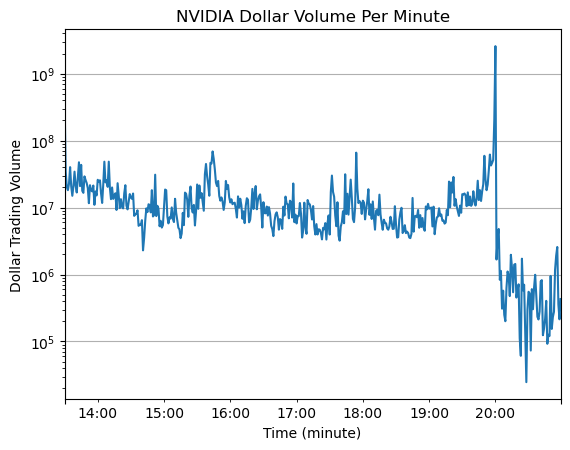

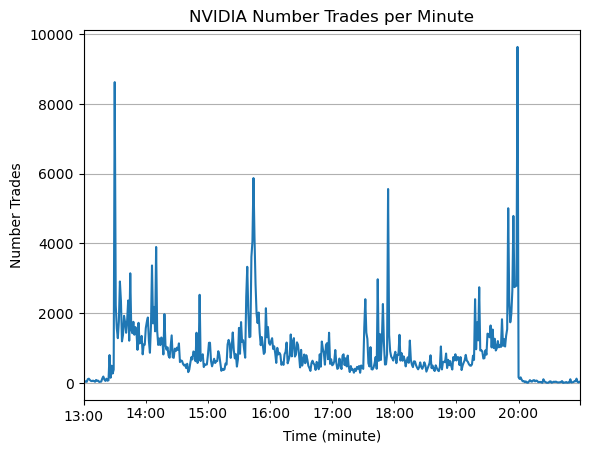

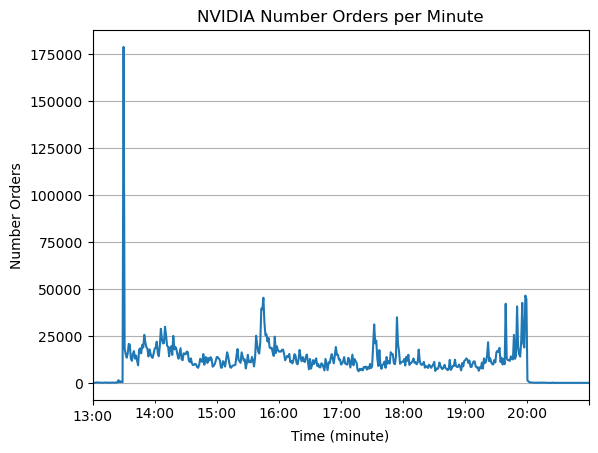



NVIDIA Open:  129.89
NVIDIA Close:  124.33
NVIDIA High:  130.75
NVIDIA Low:  123.1 



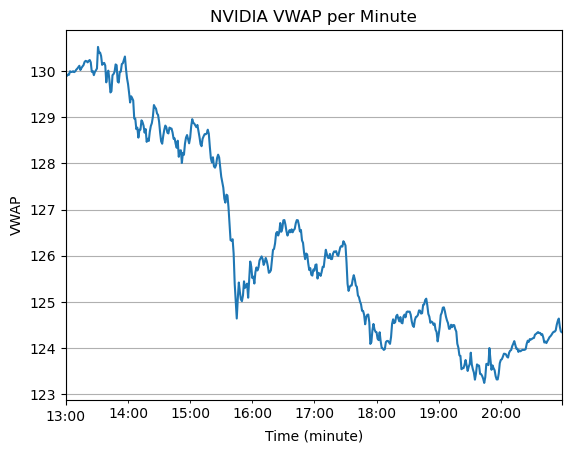

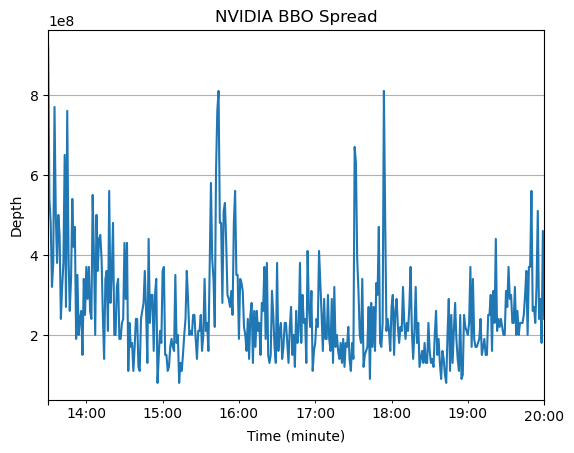

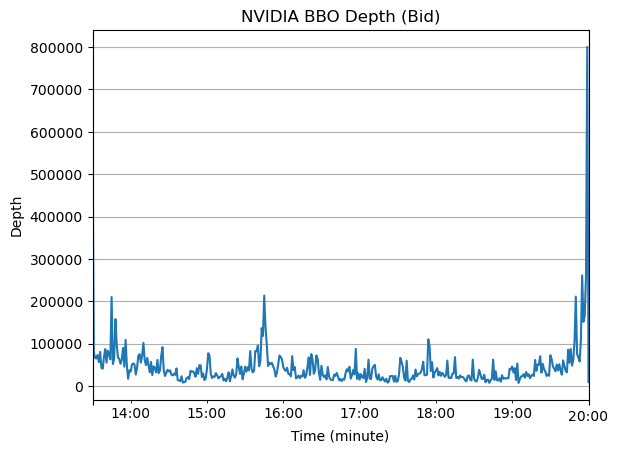

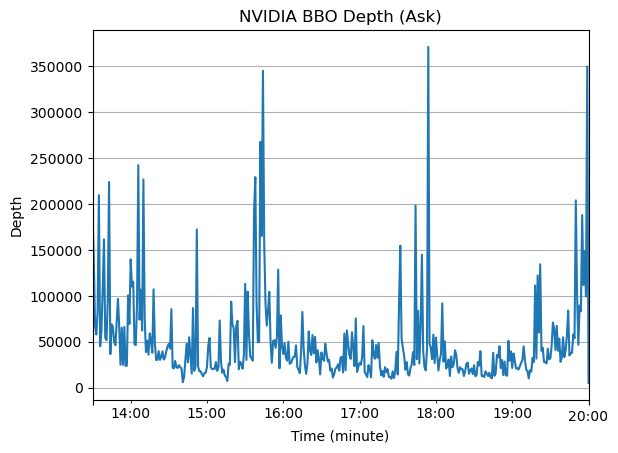

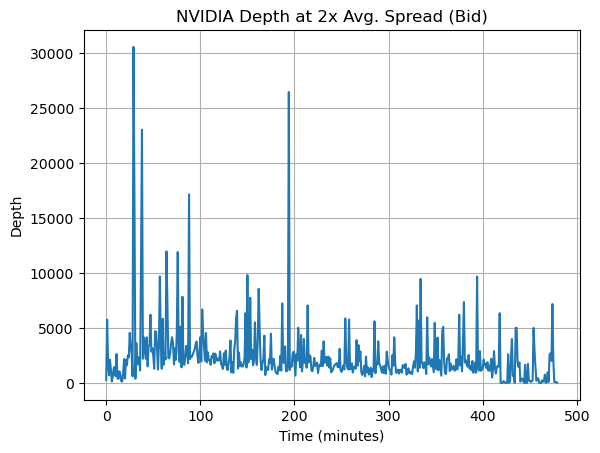

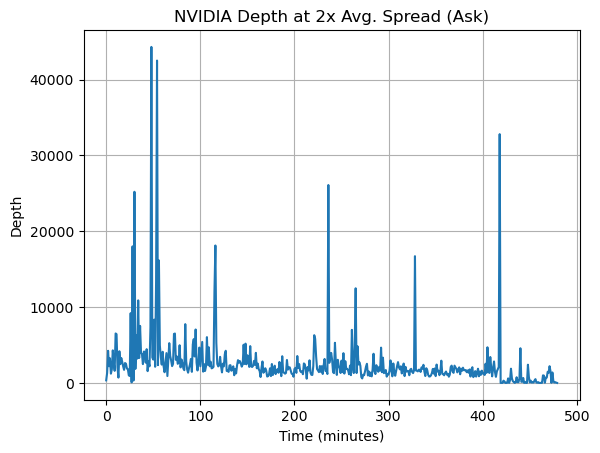

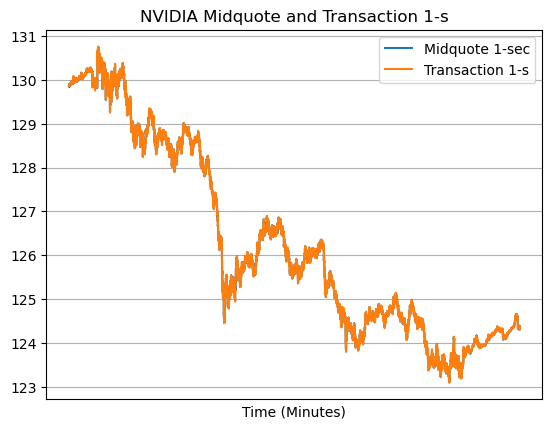

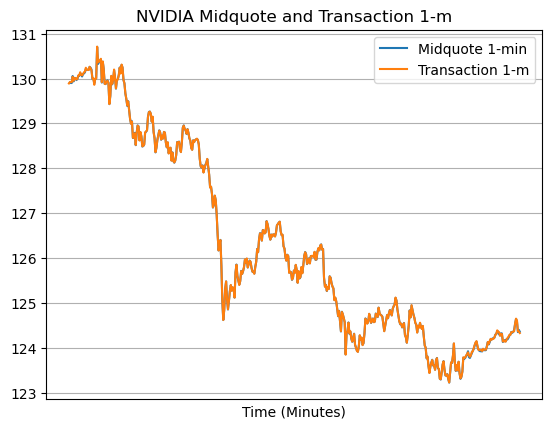

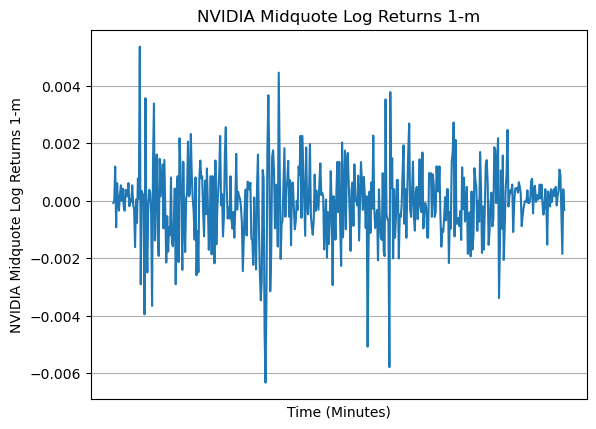

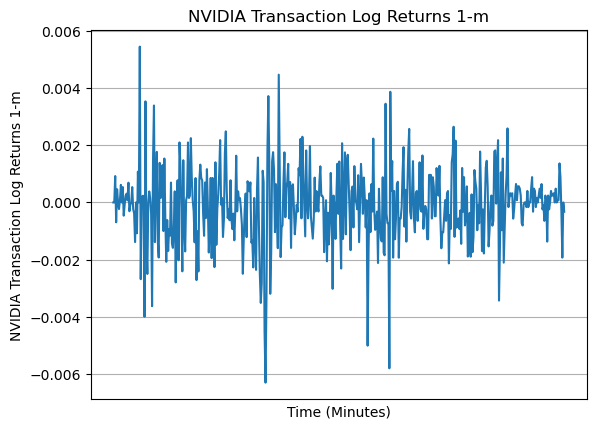

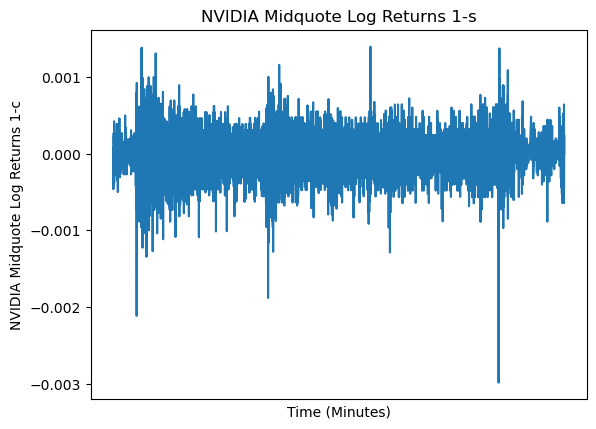

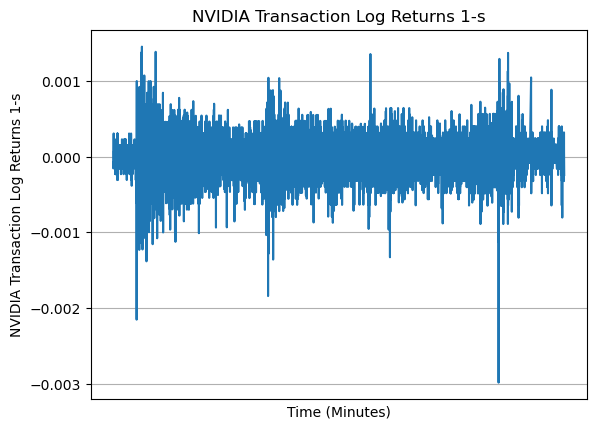

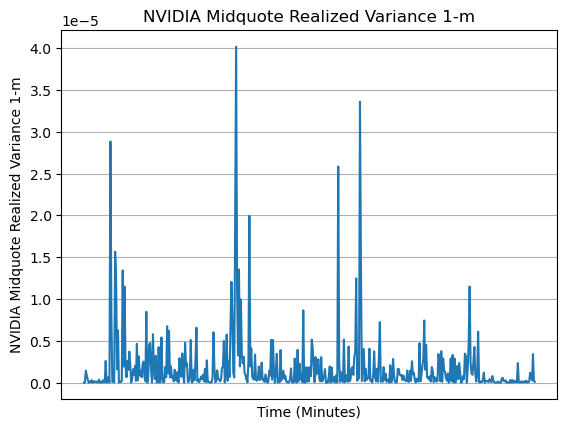

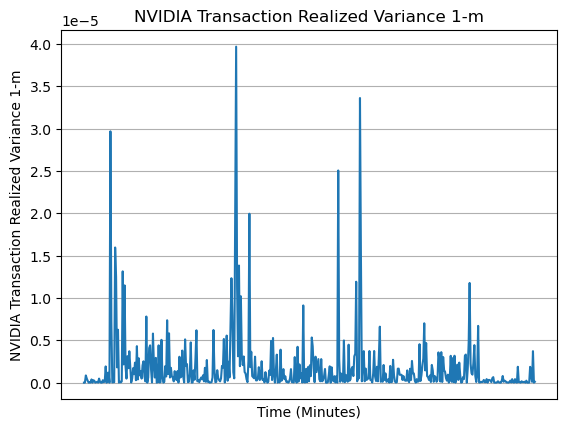

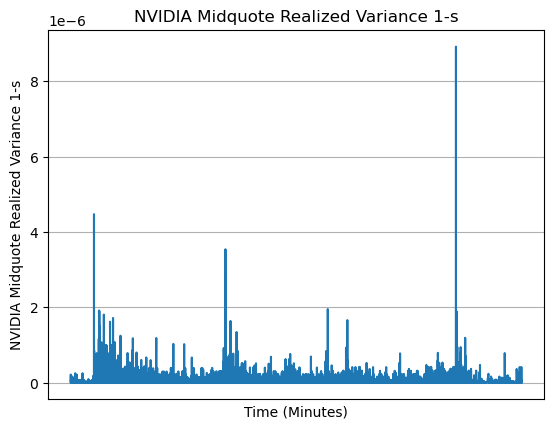

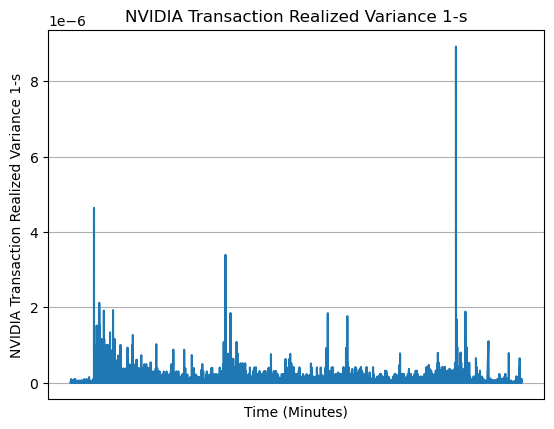

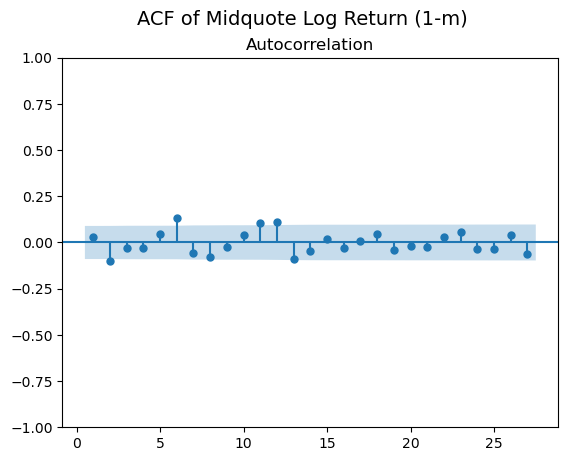

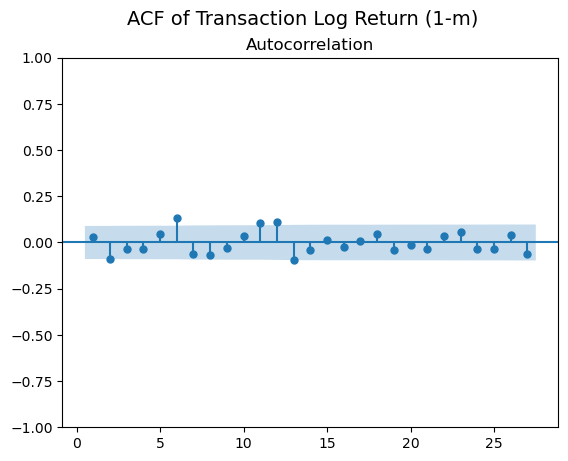

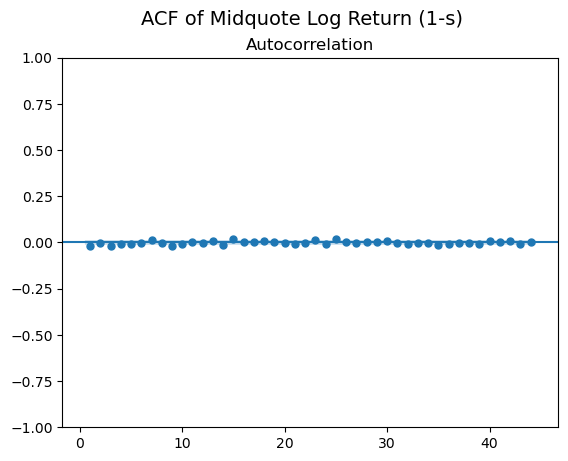

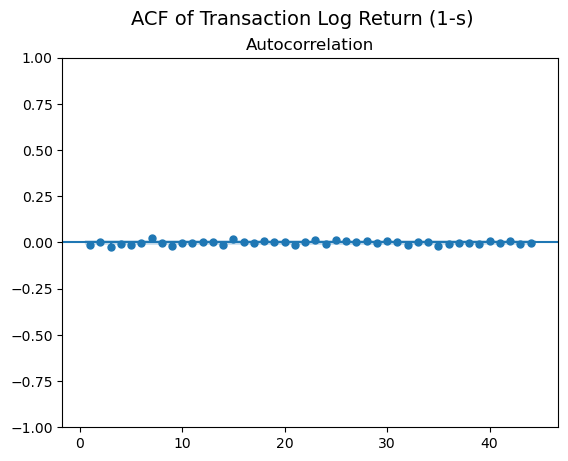

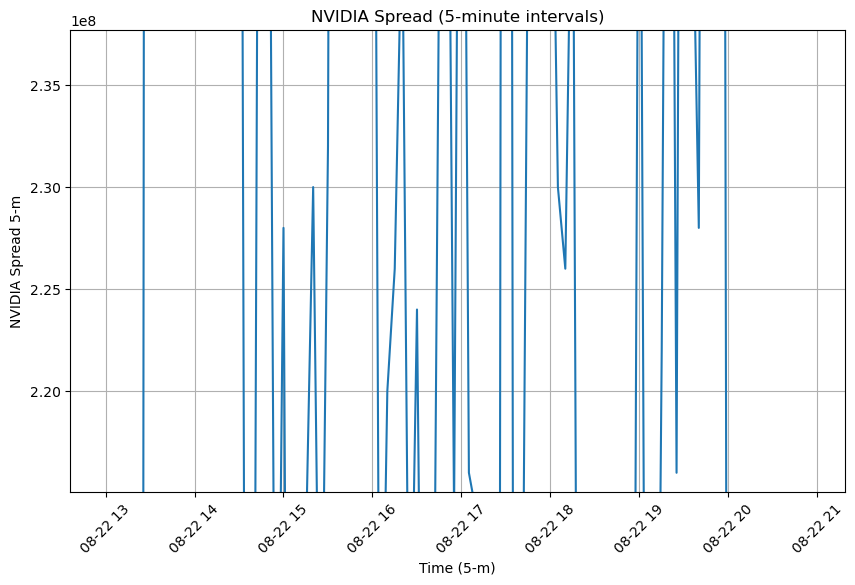

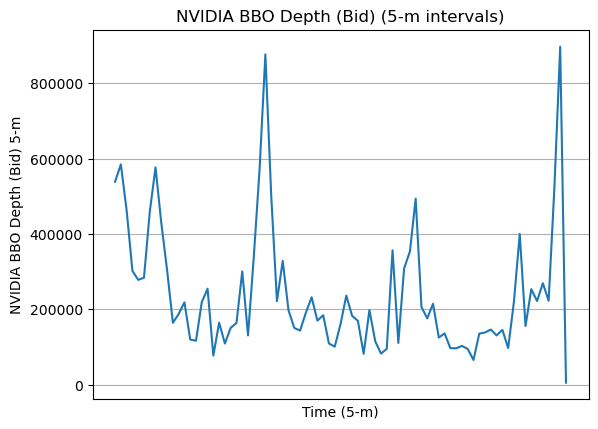

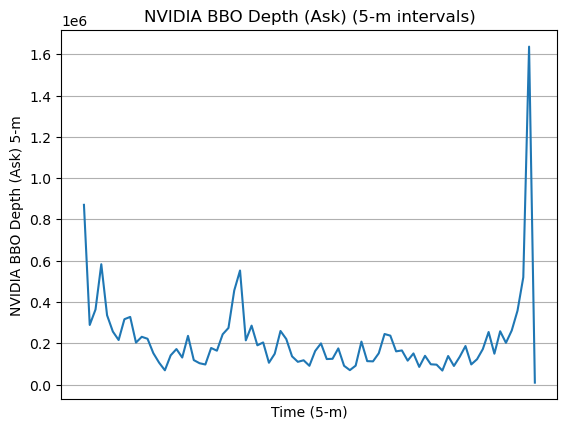

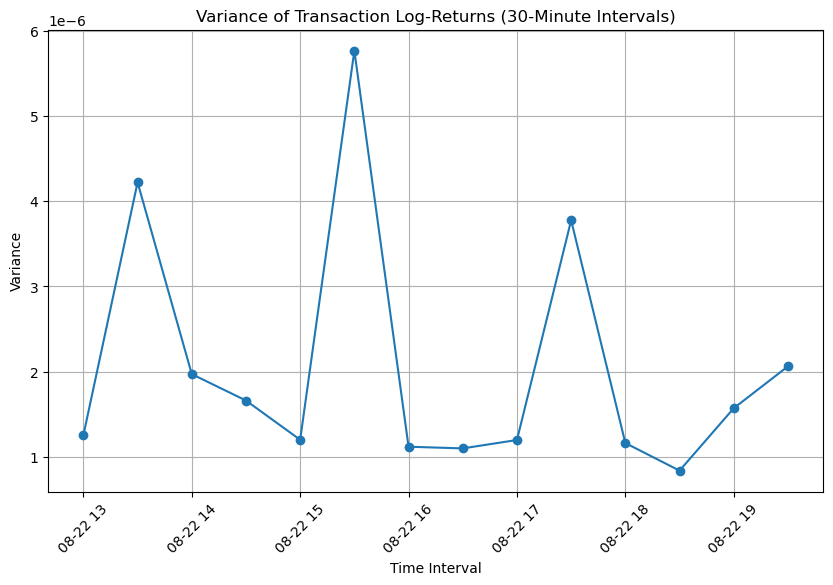

Mean Autocorrelation for Lag 1: -0.0073862425768913


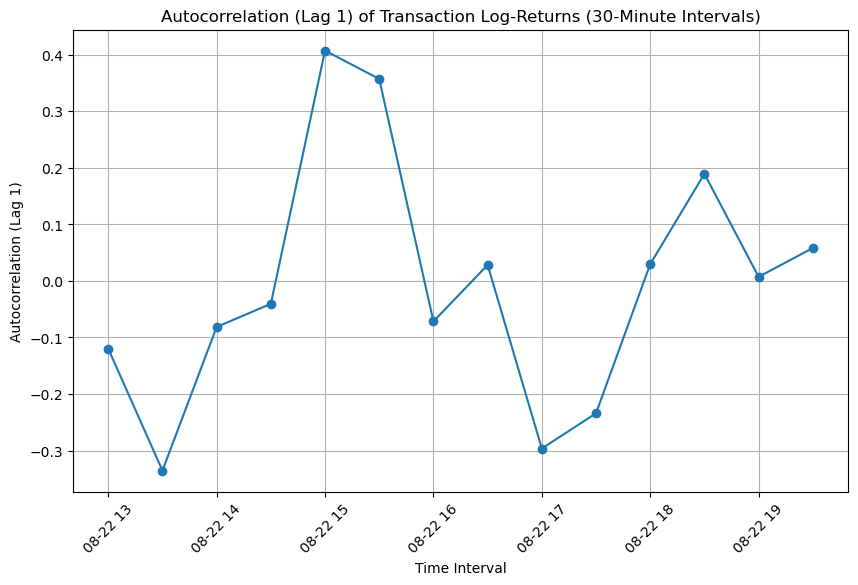

Mean Autocorrelation for Lag 2: -0.05460972044692125


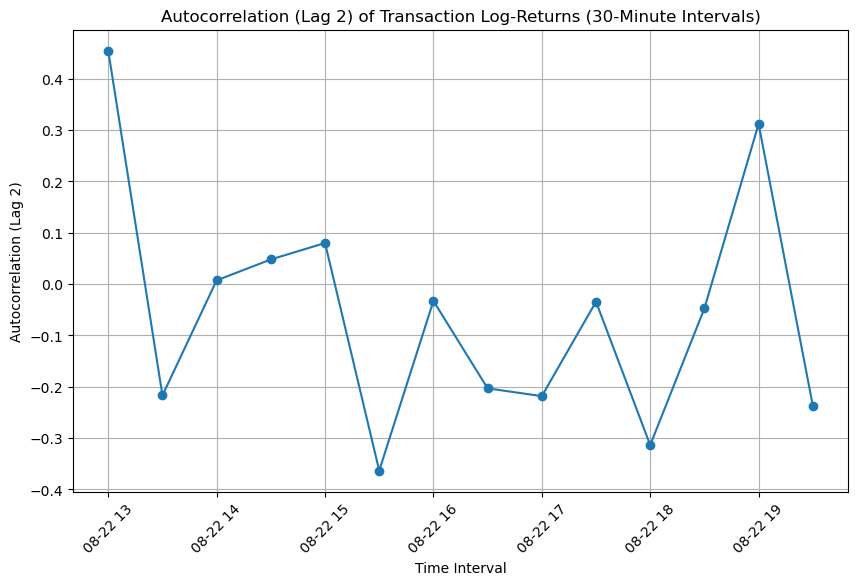

Mean Autocorrelation for Lag 3: -0.03462782087256698


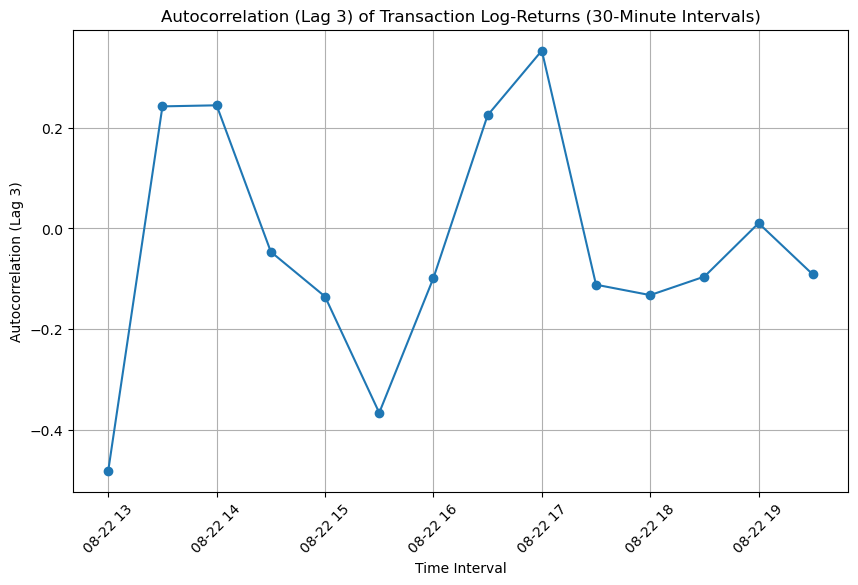

Mean Autocorrelation for Lag 10: 0.005213446297981083


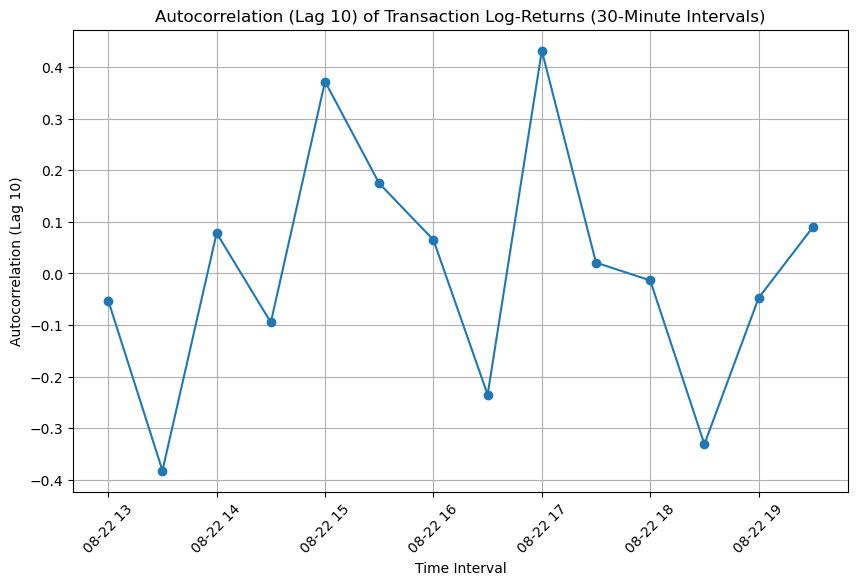

In [79]:
min_stats, sec_stats, mq_trans_1m_df, mq_trans_1s_df = calc_summary_statistics(nvda_df_mbo,nvda_df,"NVIDIA")

In [80]:
min_stats

,dollar_vol,vwap,best_bbo_spread,best_bbo_depth_bid,best_bbo_depth_ask,depth_twice_avg_spread_ask,depth_twice_avg_spread_bid,midquote_1min,transaction_1min,midquote_log_return_1min,transaction_log_return_1min,midquote_log_return_1sec,transaction_log_return_1sec
count,4.800000e+02,480.000000,4.770000e+02,477.000000,477.000000,480.000000,480.000000,480.000000,480.000000,479.000000,479.000000,23791.000000,23791.000000
mean,1.765136e+07,126.273309,2.274843e+08,36850.716981,40720.230608,2582.225000,2368.587500,126.270104,126.271198,-0.000091,-0.000091,-0.000002,-0.000002
std,1.191423e+08,2.191982,1.394993e+08,54710.588736,48275.917958,4000.234382,2832.019292,2.196114,2.196243,0.001336,0.001332,0.000194,0.000192
min,2.471430e+04,123.242287,0.000000e+00,136.000000,13.000000,0.000000,0.000000,123.225000,123.230000,-0.006338,-0.006298,-0.002986,-0.002986
25%,4.741003e+06,124.382147,1.400000e+08,13907.000000,14660.000000,1219.500000,1156.750000,124.365000,124.370000,-0.000809,-0.000802,-0.000080,-0.000080
50%,8.665574e+06,125.695048,2.100000e+08,26056.000000,27939.000000,1797.000000,1684.500000,125.695000,125.695000,0.000000,0.000000,0.000000,0.000000
75%,1.464753e+07,128.533343,2.900000e+08,45891.000000,48586.000000,2565.250000,2597.000000,128.518750,128.522500,0.000635,0.000641,0.000081,0.000080
max,2.577830e+09,130.524562,9.200000e+08,800498.000000,370989.000000,44308.000000,30574.000000,130.705000,130.710000,0.005370,0.005447,0.001397,0.001455


In [81]:
sec_stats

,midquote_1sec,transaction_1sec
count,23792.000000,23792.000000
mean,126.369438,126.369682
std,2.129374,2.129677
min,123.110000,123.105000
25%,124.575000,124.570000
50%,125.855000,125.860000
75%,128.545000,128.550000
max,130.745000,130.750000


In [82]:
mq_trans_1m_df

,midquote_realized_variance_1m,transaction_realized_variance_1m
ts_event,,
2024-08-22 13:01:00+00:00,3.704064e-08,5.333236e-08
2024-08-22 13:02:00+00:00,5.925817e-09,0.000000e+00
2024-08-22 13:03:00+00:00,0.000000e+00,0.000000e+00
2024-08-22 13:04:00+00:00,1.422090e-06,8.523334e-07
2024-08-22 13:05:00+00:00,8.521367e-07,4.793268e-07
...,...,...
2024-08-22 20:55:00+00:00,7.795053e-07,7.794427e-07
2024-08-22 20:56:00+00:00,2.720843e-07,1.030089e-07
2024-08-22 20:57:00+00:00,3.414770e-06,3.716668e-06


In [83]:
mq_trans_1s_df

,midquote_realized_variance_1s,transaction_realized_variance_1s
ts_event,,
2024-08-22 13:00:08+00:00,1.482424e-09,0.000000e+00
2024-08-22 13:00:13+00:00,5.929468e-09,5.927642e-09
2024-08-22 13:00:14+00:00,0.000000e+00,0.000000e+00
2024-08-22 13:00:16+00:00,3.704919e-08,2.371605e-08
2024-08-22 13:00:17+00:00,2.134609e-07,0.000000e+00
...,...,...
2024-08-22 20:59:35+00:00,4.139266e-07,1.035066e-07
2024-08-22 20:59:37+00:00,1.956057e-07,6.466563e-09
2024-08-22 20:59:39+00:00,0.000000e+00,0.000000e+00


# CAKE Summary Statistics

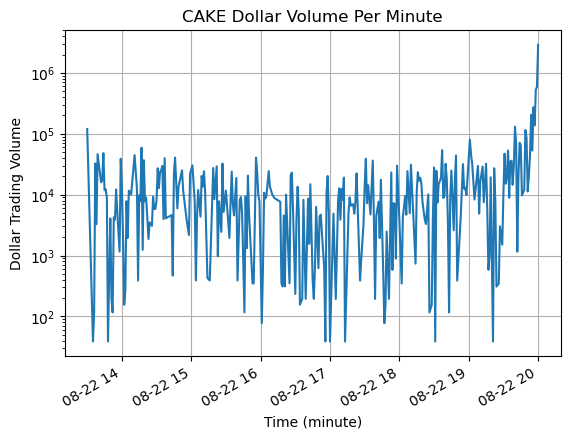

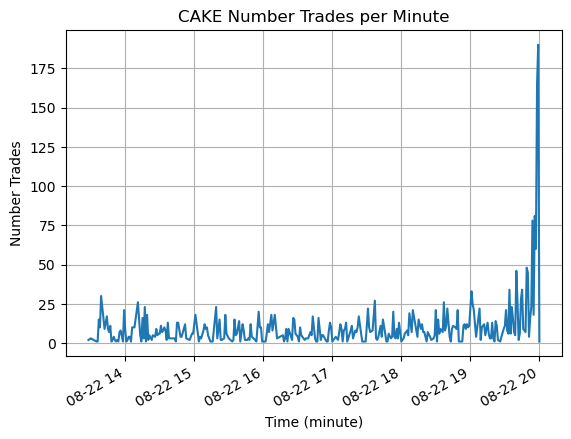

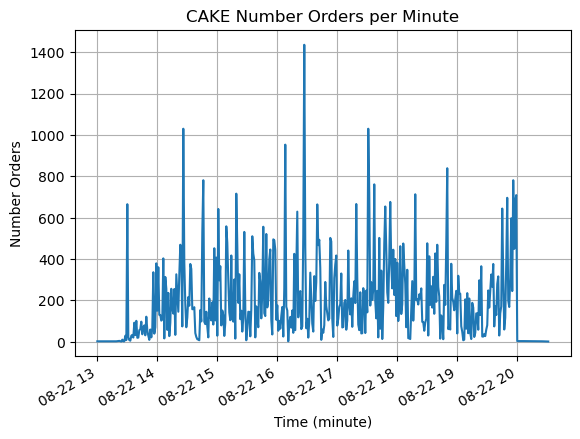



CAKE Open:  38.76
CAKE Close:  38.36
CAKE High:  39.09
CAKE Low:  38.265 



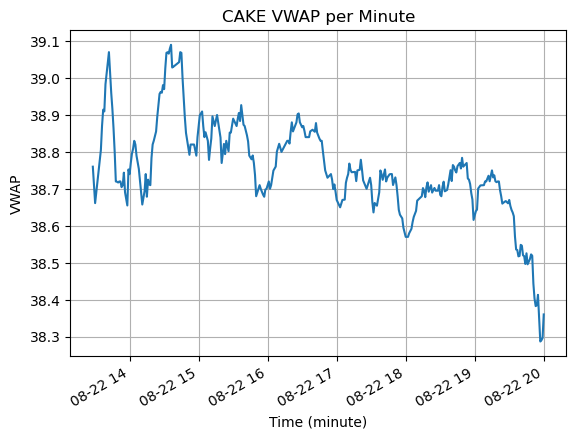

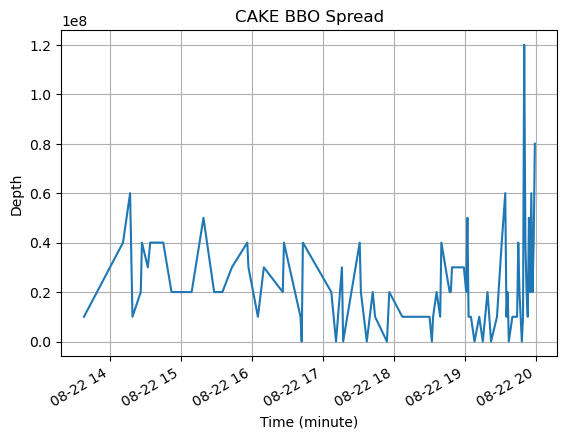

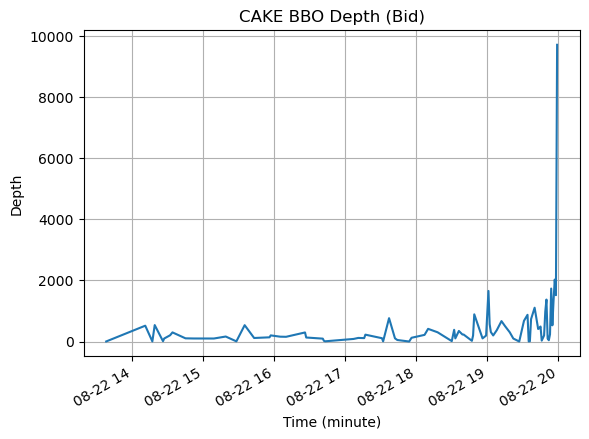

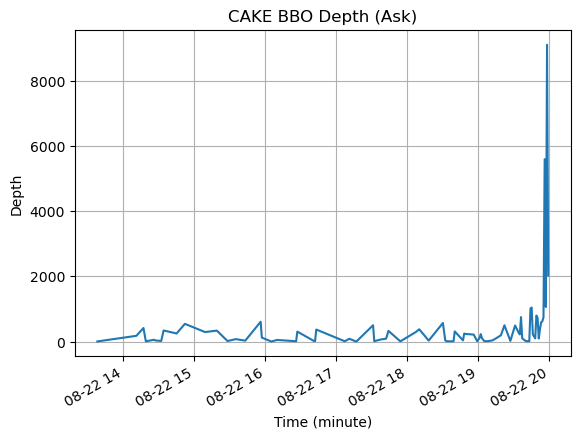

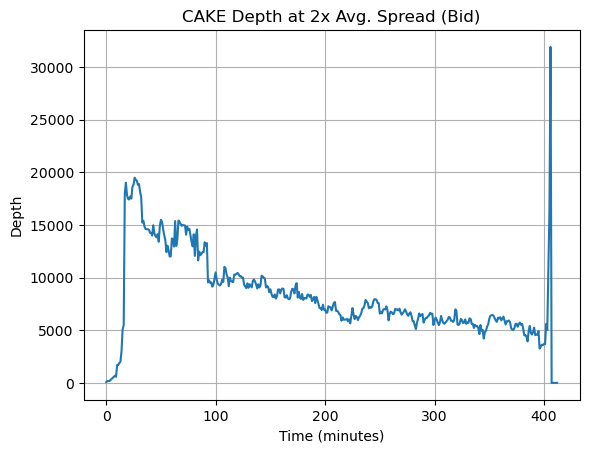

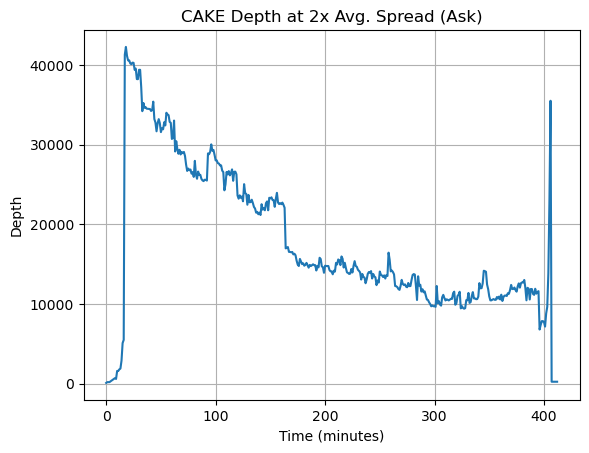

                             OLS Regression Results                             
Dep. Variable:     midquote_return_5sec   R-squared:                       0.123
Model:                              OLS   Adj. R-squared:                  0.106
Method:                   Least Squares   F-statistic:                     7.424
Date:                  Sun, 01 Sep 2024   Prob (F-statistic):            0.00870
Time:                          02:00:54   Log-Likelihood:                 310.26
No. Observations:                    55   AIC:                            -616.5
Df Residuals:                        53   BIC:                            -612.5
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.123e-05      0.000

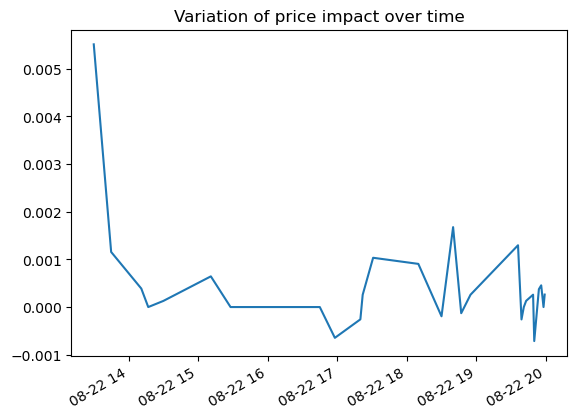

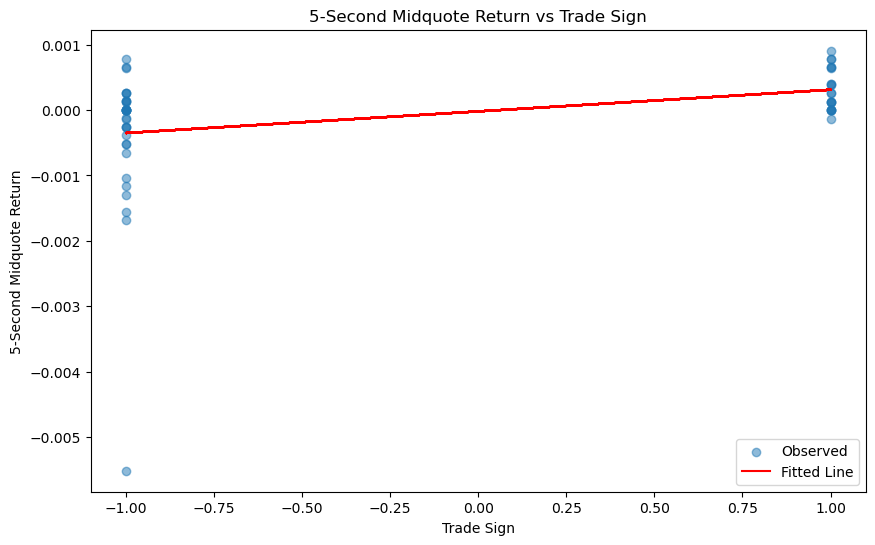

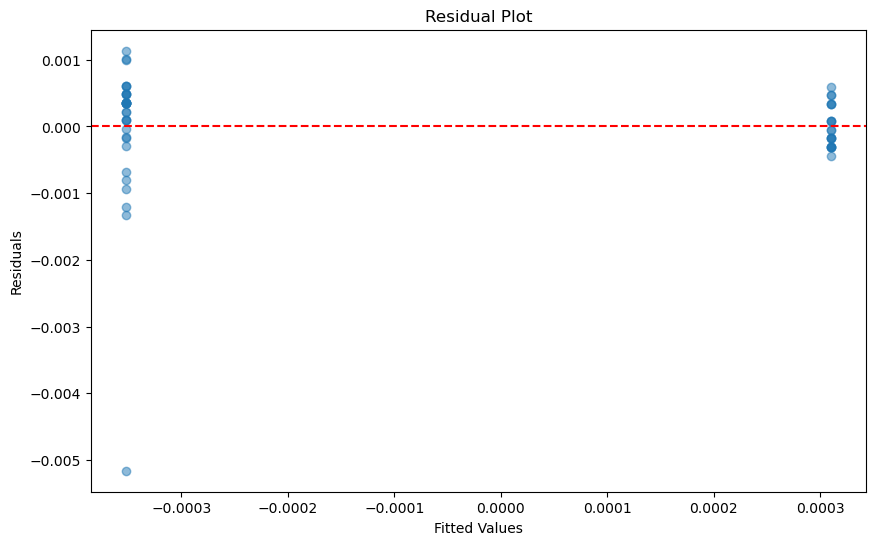

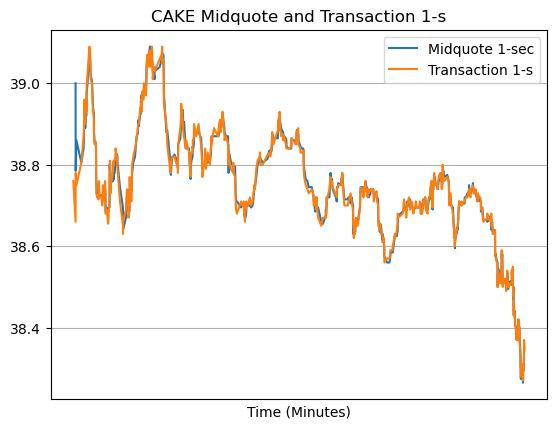

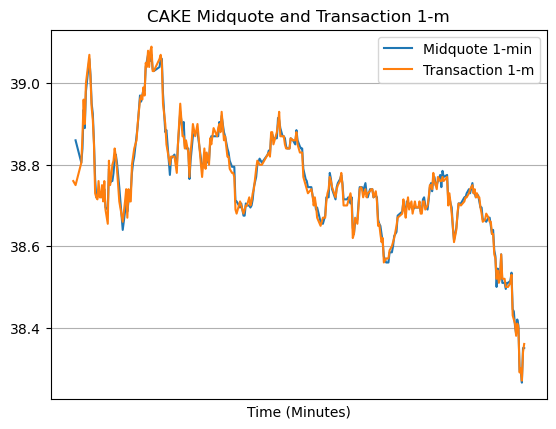

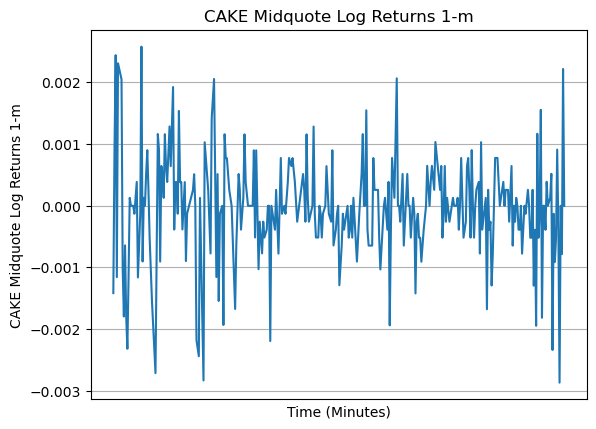

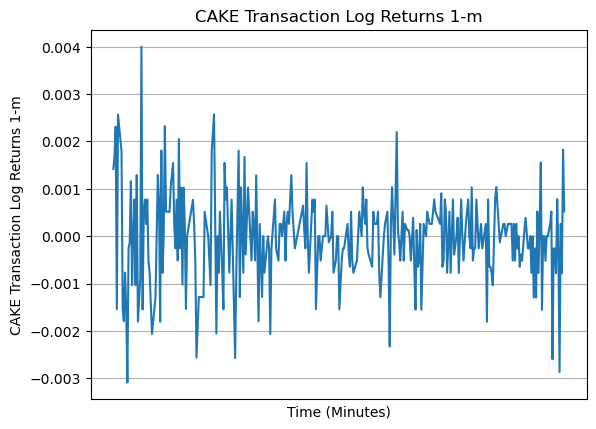

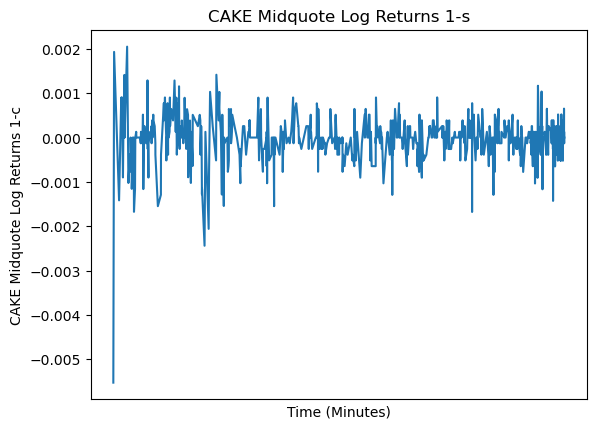

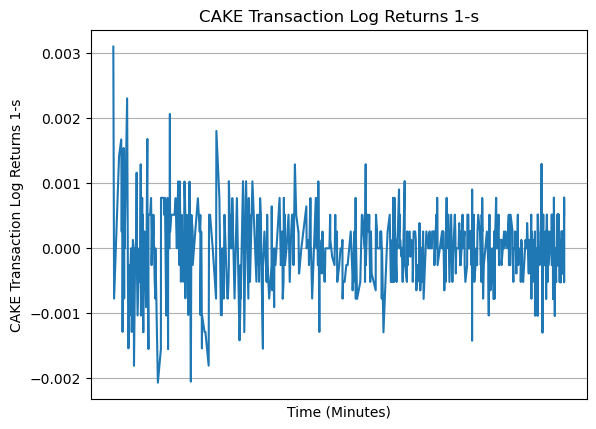

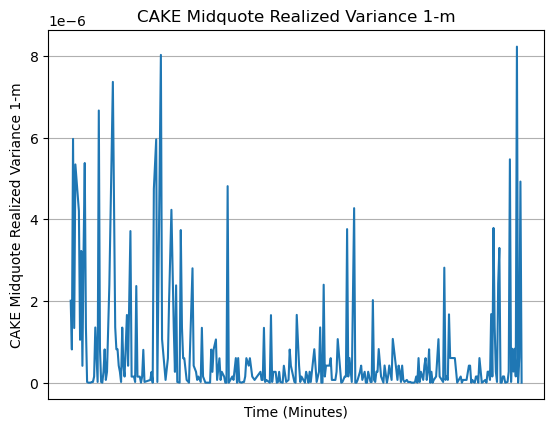

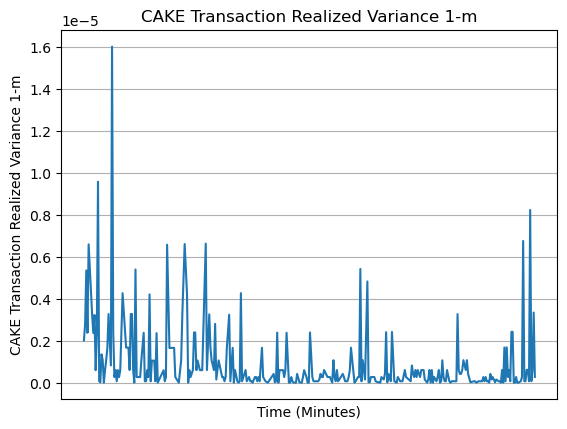

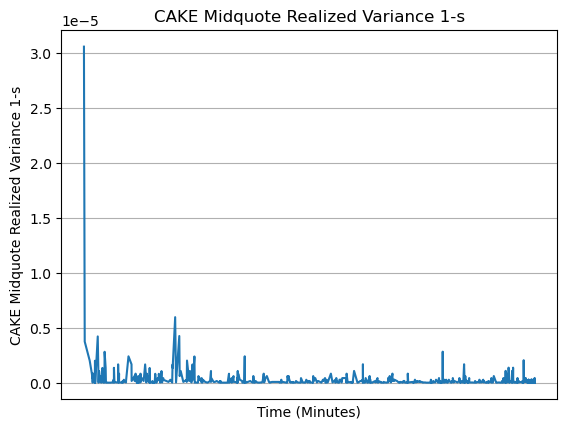

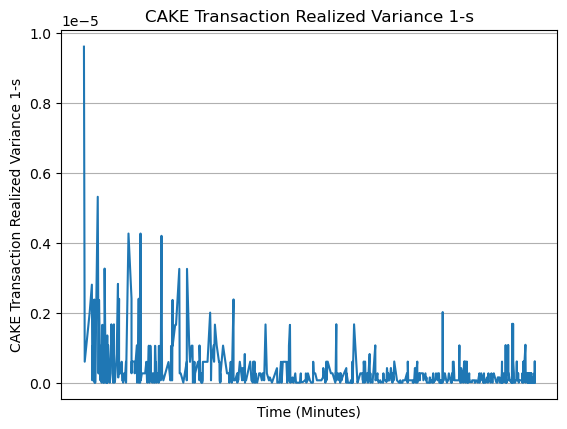

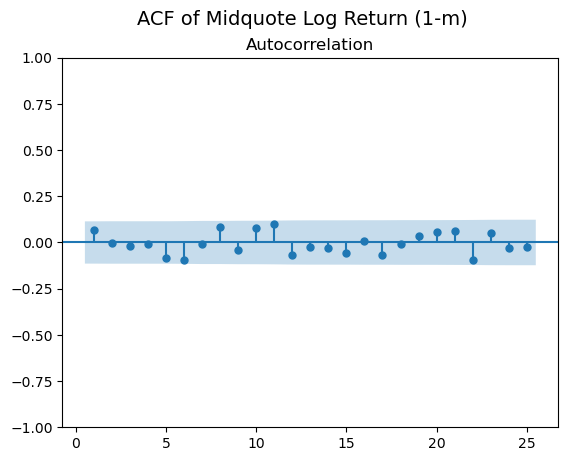

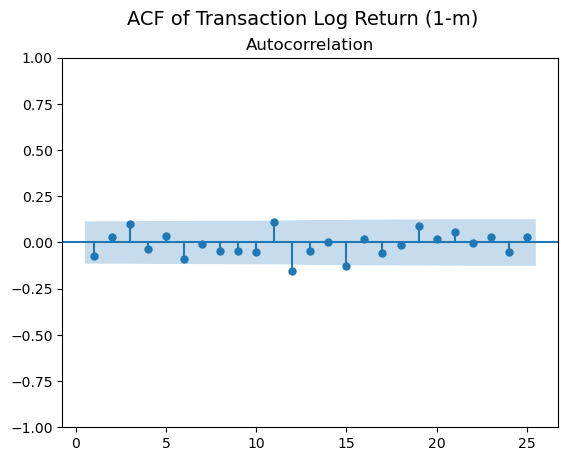

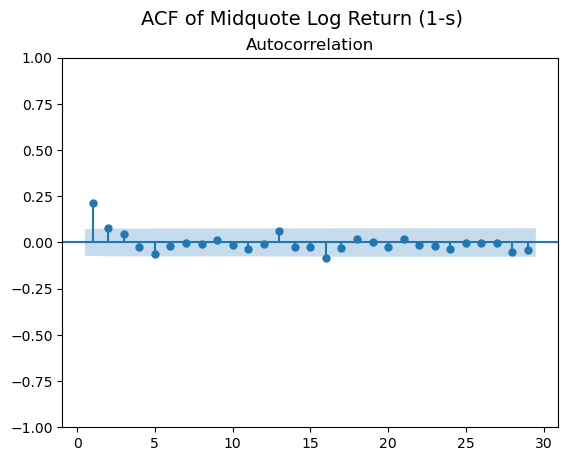

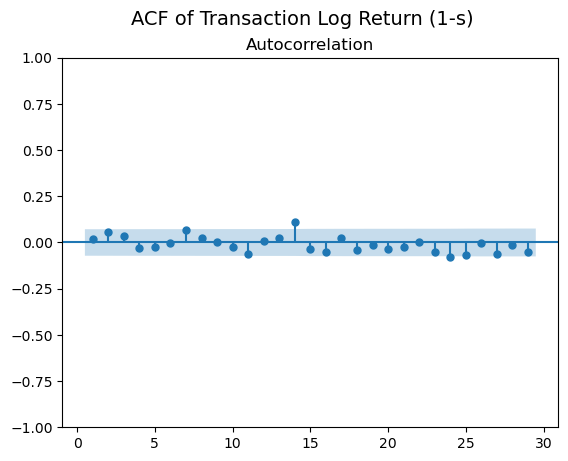

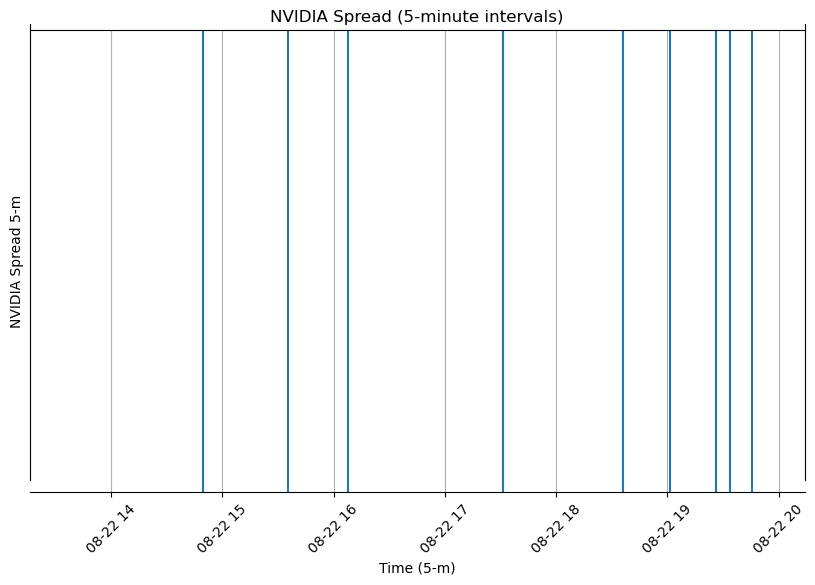

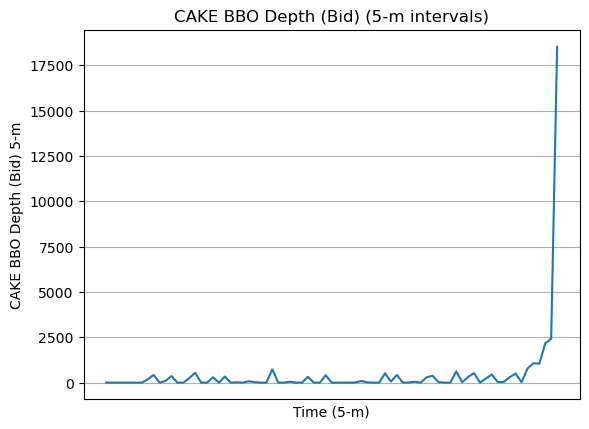

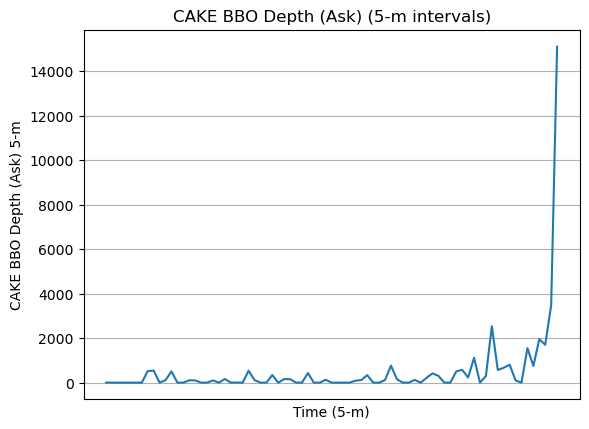

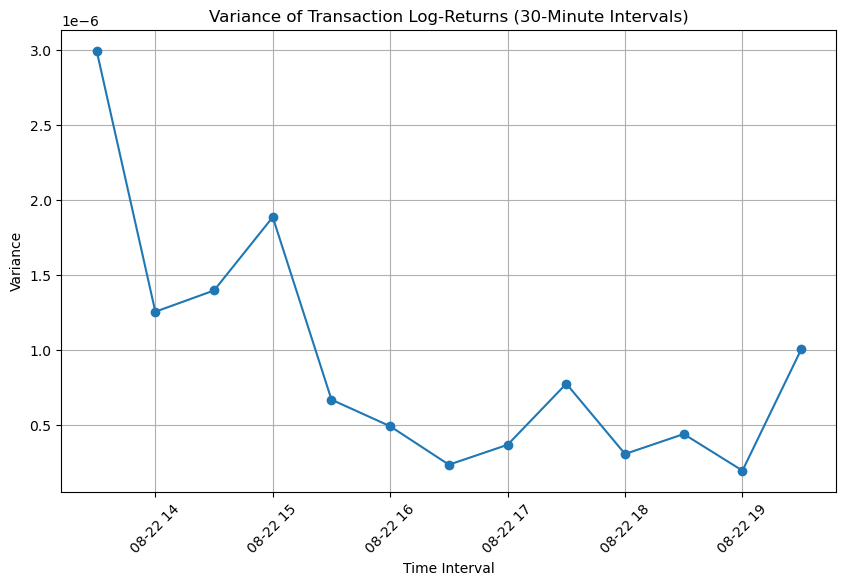

Mean Autocorrelation for Lag 1: -0.09285693647430865


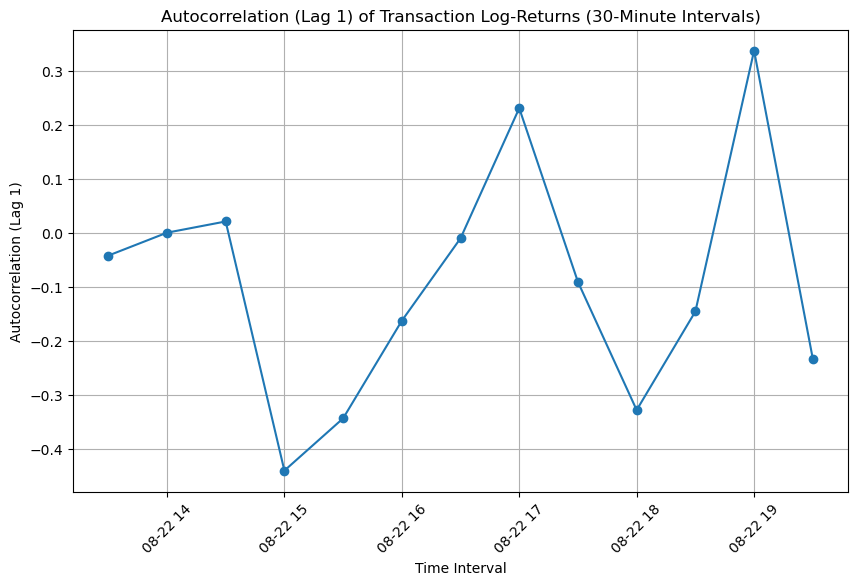

Mean Autocorrelation for Lag 2: 0.009082937247478952


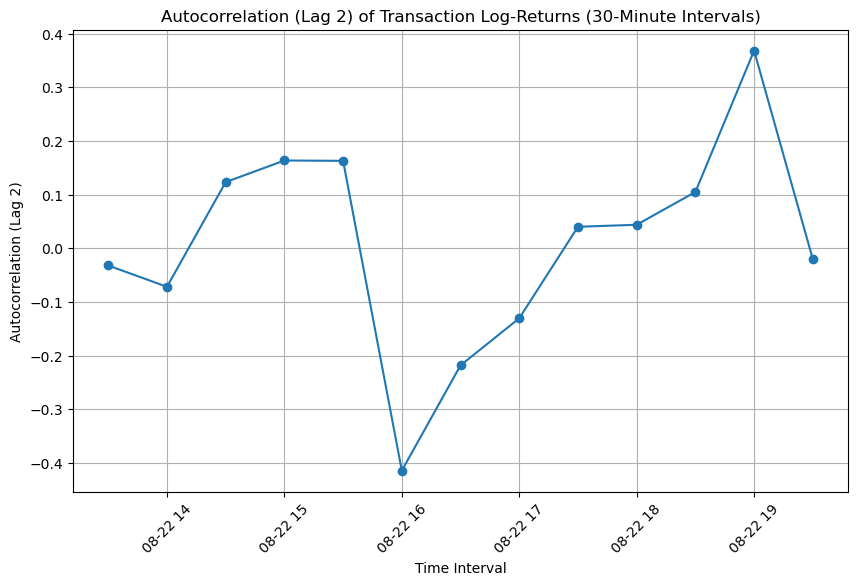

Mean Autocorrelation for Lag 3: 0.05451112975644942


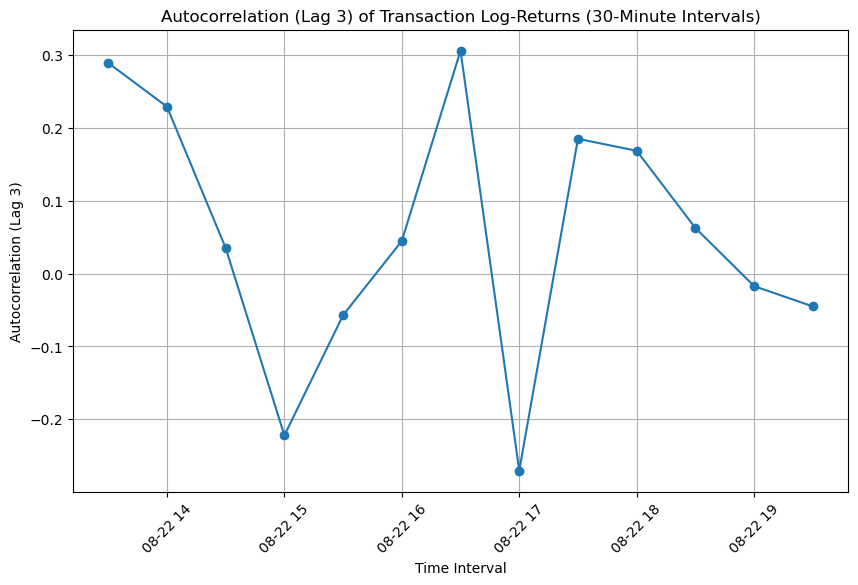

Mean Autocorrelation for Lag 10: -0.0963487080268019


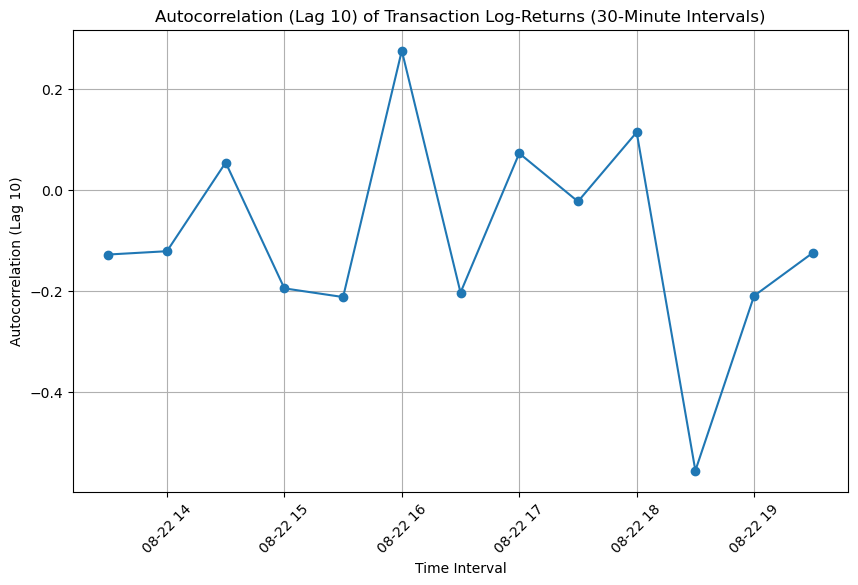

In [41]:
# Filter to get rid of post-close trades
start_time = pd.Timestamp('2024-08-22 13:00:00', tz='UTC')
end_time = pd.Timestamp('2024-08-22 21:00:00', tz='UTC')

filtered_cake_df = cake_df[(cake_df['ts_event'] >= start_time) & (cake_df['ts_event'] <= end_time)]
filtered_cake_df_mbo = cake_df_mbo[(cake_df_mbo['ts_event'] >= start_time) & (cake_df_mbo['ts_event'] <= end_time)]

min_stats, sec_stats, mq_trans_1m_df, mq_trans_1s_df = calc_summary_statistics(filtered_cake_df_mbo,filtered_cake_df,"CAKE")


In [85]:
min_stats

,dollar_vol,vwap,best_bbo_spread,best_bbo_depth_bid,best_bbo_depth_ask,depth_twice_avg_spread_ask,depth_twice_avg_spread_bid,midquote_1min,transaction_1min,midquote_log_return_1min,transaction_log_return_1min,midquote_log_return_1sec,transaction_log_return_1sec
count,2.950000e+02,295.000000,8.100000e+01,81.000000,81.000000,413.000000,413.000000,295.000000,295.000000,294.000000,294.000000,746.000000,746.000000
mean,2.932260e+04,38.746930,2.345679e+07,477.308642,433.086420,17709.276029,8263.515738,38.749508,38.746678,-0.000080,-0.000035,-0.000032,-0.000014
std,1.754346e+05,0.136508,2.019656e+07,1126.067001,1188.641727,9315.634407,4058.987688,0.140231,0.137945,0.001038,0.000960,0.000551,0.000552
min,3.867000e+01,38.286692,0.000000e+00,2.000000,4.000000,100.000000,18.000000,38.265000,38.270000,-0.010368,-0.003094,-0.006772,-0.002583
25%,2.537525e+03,38.690265,1.000000e+07,100.000000,21.000000,11522.000000,5910.000000,38.695000,38.690000,-0.000389,-0.000517,-0.000257,-0.000259
50%,8.235115e+03,38.736667,2.000000e+07,200.000000,115.000000,14208.000000,7098.000000,38.740000,38.740000,0.000000,0.000000,0.000000,0.000000
75%,1.990863e+04,38.830000,4.000000e+07,505.000000,379.000000,25007.000000,9711.000000,38.840000,38.830000,0.000386,0.000516,0.000225,0.000258
max,2.895873e+06,39.090000,1.200000e+08,9702.000000,9102.000000,42263.000000,31894.000000,39.265000,39.090000,0.002581,0.004002,0.002050,0.003099


In [86]:
sec_stats

,midquote_1sec,transaction_1sec
count,747.000000,747.000000
mean,38.696981,38.696185
std,0.180213,0.178982
min,38.265000,38.270000
25%,38.632500,38.630000
50%,38.720000,38.715000
75%,38.810000,38.810000
max,39.265000,39.090000


In [87]:
mq_trans_1m_df

,midquote_realized_variance_1m,transaction_realized_variance_1m
ts_event,,
2024-08-22 13:30:00+00:00,1.074973e-04,6.658011e-08
2024-08-22 13:35:00+00:00,2.006018e-06,2.011712e-06
2024-08-22 13:36:00+00:00,8.127728e-07,2.801073e-06
2024-08-22 13:37:00+00:00,5.967983e-06,5.348738e-06
2024-08-22 13:38:00+00:00,1.337355e-06,2.375384e-06
...,...,...
2024-08-22 19:56:00+00:00,8.227260e-06,8.229406e-06
2024-08-22 19:57:00+00:00,0.000000e+00,6.818924e-08
2024-08-22 19:58:00+00:00,6.141843e-07,6.140239e-07


In [88]:
mq_trans_1s_df

,midquote_realized_variance_1s,transaction_realized_variance_1s
ts_event,,
2024-08-22 13:30:00+00:00,4.585850e-05,6.673507e-06
2024-08-22 13:30:05+00:00,3.055958e-05,9.604892e-06
2024-08-22 13:30:45+00:00,3.732122e-06,5.989119e-07
2024-08-22 13:35:03+00:00,2.006018e-06,2.011712e-06
2024-08-22 13:36:56+00:00,8.127728e-07,2.801073e-06
...,...,...
2024-08-22 19:59:55+00:00,0.000000e+00,6.117847e-07
2024-08-22 19:59:57+00:00,1.699623e-08,6.794063e-08
2024-08-22 19:59:58+00:00,0.000000e+00,0.000000e+00
